In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

In [2]:
from scipy.misc import imresize

### Load the game environment

In [3]:
# print(gym.envs.registry.all())
env = gym.make('BreakoutDeterministic-v4')
observation = env.reset() # This gets us the image
print (observation.shape)

INFO:gym.envs.registration:Making new env: BreakoutDeterministic-v4
[2017-11-28 16:30:15,577] Making new env: BreakoutDeterministic-v4


(210, 160, 3)


In [4]:
dir(env)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_close',
 '_closed',
 '_elapsed_seconds',
 '_elapsed_steps',
 '_ensure_no_double_wrap',
 '_env_closer_id',
 '_episode_started_at',
 '_max_episode_seconds',
 '_max_episode_steps',
 '_owns_render',
 '_past_limit',
 '_render',
 '_reset',
 '_seed',
 '_spec',
 '_step',
 'action_space',
 'class_name',
 'close',
 'configure',
 'env',
 'metadata',
 'observation_space',
 'render',
 'reset',
 'reward_range',
 'seed',
 'spec',
 'step',
 'unwrapped']

In [5]:
frame, reward, is_done, _ = env.step(env.action_space.sample())

In [6]:
print (frame.shape, frame.dtype)

(210, 160, 3) uint8


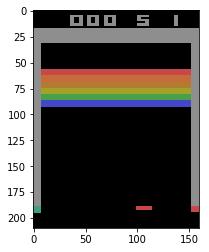

In [7]:
plt.imshow(frame)

In [41]:
def to_grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)

def crop(img,cropx=None,cropy=None):
    y,x,c = img.shape
    if (cropx is None) :
        cropx = min(y, x)
    if (cropy is None) :
        cropy = min(y, x)
    startx = x//2 - cropx//2
    starty = y - cropy    
    return img[starty:starty+cropy, startx:startx+cropx, :]

def preprocess(img):
#     return imresize(to_grayscale(crop(img))/127.5-1, (84, 84), 'cubic', 'F')
    return imresize(crop(img)/127.5-1, (84, 84), 'cubic', 'RGB')

def transform_reward(reward):
        return np.sign(reward)

(84, 84, 3) uint8 255 0 46.4648053666


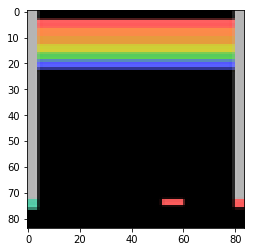

In [42]:
a = preprocess(frame)
plt.imshow(a)
print (a.shape, a.dtype, np.max(a), np.min(a), np.mean(a))
# plt.imshow(to_grayscale(frame))

In [62]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [75]:
def processState(states):
    return np.reshape(states,[21168*4]) # 84 x 84 x 3

In [76]:
def addToHistory(his, s):
    his.pop(0)
    his.append(s)

In [77]:
def his2np(his):
    return np.concatenate(tuple(his), axis=2)

In [78]:
def state2input(his, s):
    addToHistory(his, preprocess(s))
    return his2np(his)

In [87]:
state_history = []
s = env.reset()
for idx in range(4):
    state_history.append(preprocess(s))
print (s.shape)
s = state2input(state_history, s)
s = processState(s)
print (s.shape)
s = env.reset()
s = state2input(state_history, s)
s = processState(s)
print (s.shape)

(210, 160, 3)
(84672,)
(84672,)


In [79]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [89]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        #We use slim.conv2d to set up our network 
        self.scalarInput =  tf.placeholder(shape=[None,21168*4],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3*4])
#         self.conv1 = slim.conv2d( \
#             inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
#         self.conv2 = slim.conv2d( \
#             inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
#         self.conv3 = slim.conv2d( \
#             inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
#         self.conv4 = slim.conv2d( \
#             inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        
        ################################################################################
        # TODO: Implement Dueling DQN                                                  #
        # We take the output from the final convolutional layer i.e. self.conv4 and    #
        # split it into separate advantage and value streams.                          #
        # Outout: self.Advantage, self.Value                                           #
        # Hint: Refer to Fig.1 in [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf)  #
        #       In implementation, use tf.split to split into two branches. You may    #
        #       use xavier_initializer for initializing the two additional linear      #
        #       layers.                                                                # 
        ################################################################################
        pass
        init = tf.contrib.layers.xavier_initializer()
        V_split, A_split = tf.split(self.conv4, 2, 3)
#         V_split = tf.reshape(V_split, [-1, h_size])
#         A_split = tf.reshape(A_split, [-1, h_size])
        V_split = slim.flatten(V_split)
        A_split = slim.flatten(A_split)
        self.Value = tf.layers.dense(V_split, 1, kernel_initializer=init)
        self.Advantage = tf.layers.dense(A_split, env.action_space.n, kernel_initializer=init)
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        #Then combine them together to get our final Q-values. 
        #Please refer to Equation (9) in [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf)
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.action_space.n,dtype=tf.float32)
        
        ################################################################################
        # TODO:                                                                        #
        # Obtain the loss (self.loss) by taking the sum of squares difference          #
        # between the target and prediction Q values.                                  #
        ################################################################################
        pass
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        self.loss = tf.reduce_sum(tf.square(self.Q-self.targetQ))
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### Training the network

Setting all the training parameters

In [92]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 5000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 500 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn_breakout" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [94]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0


#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        state_history = []
        for idx in range(4):
            state_history.append(preprocess(s))
        s = state2input(state_history, s)
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
#         while j < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trial.
        while True:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            total_steps += 1
            
            ################################################################################
            # TODO: Save the experience to our episode buffer.                             #
            # You will need to do the following:                                           #
            # (1) Get new state s1 (resized), reward r and done d from a                   #
            # (2) Add experience to episode buffer. Hint: experience includes              #
            #     s, a, r, s1 and d.                                                       #
            ################################################################################
            pass
#             r = 0
#             d = False
#             for idx in range(4):
#                 _s1, _r, _d, _ = env.step(a)
#                 s1 = state2input(state_history, _s1)
#                 r += _r
#                 d = d or _d
            s1, r, d, _ = env.step(a)
                
            r = transform_reward(r)
            s1 = processState(s1)
            episodeBuffer.add(np.reshape(np.array([s, a, r, s1, d]), [1, 5]))
            ################################################################################
            #                                 END OF YOUR CODE                             #
            ##############################################################################
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    
                    ################################################################################
                    # TODO: Implement Double-DQN                                                   #
                    # (1) Get a random batch of experiences via experience_buffer class            #
                    #                                                                              #
                    # (2) Perform the Double-DQN update to the target Q-values                     #
                    #     Hint: Use mainQN and targetQN separately to chose an action and predict  #
                    #     the Q-values for that action.                                            #
                    #     Then compute targetQ based on Double-DQN equation                        #
                    #                                                                              #
                    # (3) Update the primary network with our target values                        #
                    ################################################################################ 
                    pass
                    exp_batch = myBuffer.sample(batch_size)
                    s_batch = np.vstack(exp_batch[:, 0])
                    a_batch = exp_batch[:, 1]
                    r_batch = exp_batch[:, 2]
                    s1_batch = np.vstack(exp_batch[:, 3])
                    d_batch = exp_batch[:, 4]
#                     print (exp_batch.shape, s_batch.shape, a_batch.shape, r_batch.shape, s1_batch.shape, d_batch.shape)
                    mainQN_predict = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:s1_batch})
                    targetQN_Qout = sess.run(targetQN.Qout, feed_dict={targetQN.scalarInput:s1_batch})
                    targetQN_Q_value = targetQN_Qout[range(batch_size), mainQN_predict]
                    end_mat = -(d_batch-1)
                    target_Q_value = r_batch + y*targetQN_Q_value*end_mat
                    target_Q_value = r_batch + y*targetQN_Q_value
                    sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput:s_batch,\
                                                           mainQN.targetQ:target_Q_value,\
                                                           mainQN.actions:a_batch})
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
                           
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print("Episode",i,"reward:",np.mean(rList[-10:]))
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Mean reward per episode: " + str(sum(rList)/num_episodes))

Saved Model
Episode 9 reward: 1.3
Episode 19 reward: 1.1
Episode 29 reward: 1.4
Episode 39 reward: 1.1
Episode 49 reward: 0.8
Episode 59 reward: 1.7
Episode 69 reward: 0.9
Episode 79 reward: 1.4
Episode 89 reward: 1.4
Episode 99 reward: 1.5
Episode 109 reward: 1.0
Episode 119 reward: 1.1
Episode 129 reward: 1.0
Episode 139 reward: 0.8
Episode 149 reward: 1.2
Episode 159 reward: 1.5
Episode 169 reward: 0.8
Episode 179 reward: 1.4
Episode 189 reward: 2.0
Episode 199 reward: 1.4
Episode 209 reward: 1.5
Episode 219 reward: 1.9
Episode 229 reward: 1.7
Episode 239 reward: 3.4
Episode 249 reward: 2.2
Episode 259 reward: 0.7
Episode 269 reward: 1.0
Episode 279 reward: 0.8
Episode 289 reward: 1.3
Episode 299 reward: 1.2
Episode 309 reward: 0.4
Episode 319 reward: 0.9
Episode 329 reward: 0.4
Episode 339 reward: 0.7
Episode 349 reward: 1.7
Episode 359 reward: 2.3
Episode 369 reward: 2.3
Episode 379 reward: 2.2
Episode 389 reward: 3.6
Episode 399 reward: 4.3
Episode 409 reward: 3.7
Episode 419 rew

KeyboardInterrupt: 

It takes about 40 minutes to train 5000 episodes in Lab 4 machines. Mean reward per episode (50 steps) should be around 20

### Checking network learning

Mean reward over time

In [ ]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)